# LSTM Implementation

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00


# **Text Preprocessing**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
import re

In [ ]:
# Specify the filename
input_file = '/content/drive/MyDrive/AI/holmes.txt'

# Read the contents of the file
try:
    with open(input_file, 'r', encoding='utf-8') as infile:
        data = infile.read()
    print("Data loaded successfully!")
    print(f"Preview of the first 100 characters:\n{data[:100]}")
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded successfully!
Preview of the first 100 characters:
*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*

#4 in the Victor Appleton's Tom Swi


In [ ]:
data[:100] # view first few characters

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swi"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Limit data to 400000 characters
data = data[:400000]
print(f"Using {len(data)} characters for training")

Using 400000 characters for training


# Clean Text

In [ ]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters but keep spaces and basic punctuation
    text = re.sub(r'[^\w\s\.,!?]', '', text)
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    return text

# Clean the text
cleaned_text = clean_text(data)
print(f"Cleaned text sample: {cleaned_text[:100]}")

# Split into sentences - simpler approach
sentences = re.split(r'(?<=[.!?])\s+', cleaned_text)
sentences = [s.strip() for s in sentences if len(s) > 5]  # Keep only sentences with length > 5
print(f"Created {len(sentences)} sentences")

Cleaned text sample: project gutenbergs etext of tom swift and his submarine boat 4 in the victor appletons tom swift ser
Created 5768 sentences


In [ ]:
"""
What is an OOV Token?
An out-of-vocabulary (OOV) token is a special token used in natural language processing (NLP) tasks to represent words that
are not present in the vocabulary of the model or tokenizer. When a word that is not in the vocabulary is encountered during
tokenization or text processing, it is replaced with the OOV token.

Why Use an OOV Token?
Using an OOV token helps handle unseen or unknown words during the training or inference phase of an NLP model.
Instead of encountering errors or issues when encountering unknown words, the model can gracefully handle them by
representing them with the OOV token. This is particularly useful when working with real-world data where the vocabulary
of the model may not cover all possible words.
"""
# Tokenize words
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1
print(f"Total unique words: {total_words}")

# tokenizer.word_counts
# tokenizer.word_index
"""
n_gram example:
[3, 15, 8, 7, 20, 12, 6]

For the above sentece sentence, the code would generate the following n-gram sequences:

[3, 15]
[3, 15, 8]
[3, 15, 8, 7]
[3, 15, 8, 7, 20]
[3, 15, 8, 7, 20, 12]
[3, 15, 8, 7, 20, 12, 6]
"""

# Generate input sequences
input_sequences = []
for sentence in sentences:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    # Create n-grams starting from 2 words context
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print(f"Total sequences created: {len(input_sequences)}")

# Find max sequence length
max_sequence_len = min(20, max([len(x) for x in input_sequences]))
print(f"Using max sequence length: {max_sequence_len}")

# Pad sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
print(f"Input shape: {input_sequences.shape}")

Total unique words: 5469
Total sequences created: 65300
Using max sequence length: 20
Input shape: (65300, 20)


In [ ]:
# Prepare X (input) and y (target)
X, labels = input_sequences[:,:-1], input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (65300, 19), y shape: (65300, 5469)


In [ ]:
from sklearn.model_selection import train_test_split

# Simple split without using sklearn to reduce dependencies
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

Training set: (52240, 19), Validation set: (13060, 19)


# Train LSTM Model

In [ ]:
# Define your model
model = Sequential()
model.add(Embedding(total_words, 128, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Add return_sequences=True
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))  # Add a second LSTM layer
model.add(Dropout(0.3))
model.add(Dense(total_words//2, activation='relu'))  # Add intermediate layer
model.add(Dense(total_words, activation='softmax'))

model.build(input_shape=(None, max_sequence_len-1))
model.summary()

adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 19, 128)        │       700,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 19, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 19, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2734)           │       352,686 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5469)           │    14,957,715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,437,953 (62.71 MB)

 Trainable params: 16,437,953 (62.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Add early stopping to prevent overtraining
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.0001
)

# Train with smaller batch size to reduce memory usage
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - accuracy: 0.1389 - loss: 5.2088 - val_accuracy: 0.1175 - val_loss: 6.2978
Epoch 2/30
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.1459 - loss: 4.9731 - val_accuracy: 0.1249 - val_loss: 6.3921
Epoch 3/30
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.1579 - loss: 4.7627 - val_accuracy: 0.1301 - val_loss: 6.4471
Epoch 4/30
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.1661 - loss: 4.6156 - val_accuracy: 0.1354 - val_loss: 6.6137
Epoch 5/30
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.1775 - loss: 4.4489 - val_accuracy: 0.1373 - val_loss: 6.8321
Epoch 6/30
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.1837 - loss: 4.3387 - val_accuracy: 0.1407 - val_loss: 6.8617


# Save Models (Weights and biases)

In [ ]:
# Save model architecture as JSON file
from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("lstm_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Load model architecture from JSON file
from tensorflow.keras.models import model_from_json

with open("lstm_model.json", "r") as json_file:
    loaded_model_json = json_file.read()

# Create model from loaded architecture
loaded_model = model_from_json(loaded_model_json)

print("Model architecture loaded successfully from JSON file.")

Model architecture loaded successfully from JSON file.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


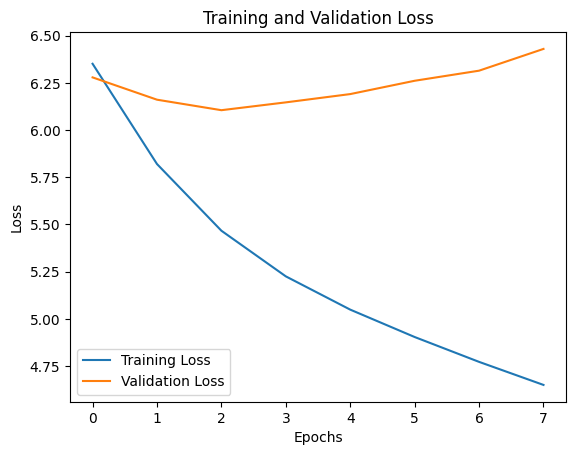

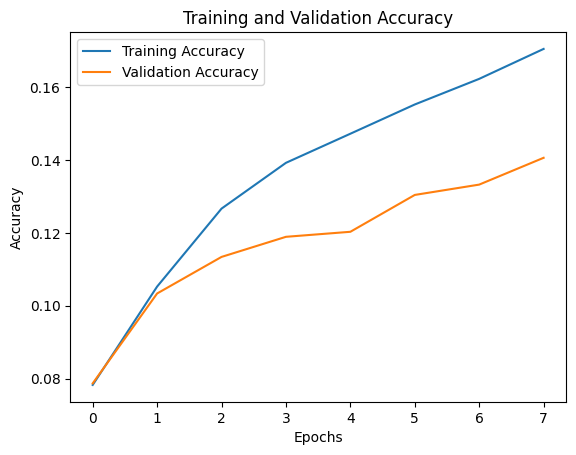

In [ ]:

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Inferences

In [ ]:
def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words


In [ ]:
# Import necessary libraries
from IPython.display import display, HTML
import ipywidgets as widgets
from google.colab import output
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set up the prediction function
def predict_top_five_words(seed_text, model, tokenizer, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

# Create the interactive app
def create_sentence_completion_app(model, tokenizer, max_sequence_len):
    # Create input widget
    text_input = widgets.Text(
        value='',
        placeholder='Type a starting phrase (e.g., "She is my")',
        description='Input:',
        layout=widgets.Layout(width='500px')
    )

    # Create button
    button = widgets.Button(
        description='Predict',
        button_style='primary',
        layout=widgets.Layout(width='100px')
    )

    # Create output area
    output_area = widgets.Output()

    # Define button click action
    def on_button_click(b):
        seed_text = text_input.value
        output_area.clear_output()

        if len(seed_text.split()) < 2:
            with output_area:
                display(HTML('<div style="color: #e74c3c; padding: 10px;">Please enter at least two words.</div>'))
            return

        with output_area:
            display(HTML('<div style="text-align: center; padding: 20px;">Loading predictions...</div>'))

        # Get predictions
        try:
            top_five = predict_top_five_words(seed_text, model, tokenizer, max_sequence_len)

            # Display results
            output_area.clear_output()
            with output_area:
                html_content = f"""
                <div style="background-color: #f5f5f5; border-radius: 10px; padding: 20px; margin-top: 20px;">
                    <h3 style="color: #2c3e50; margin-bottom: 15px;">Top 5 Predictions for: "{seed_text}"</h3>
                    <div style="display: flex; flex-direction: column; gap: 10px;">
                """

                for i, word in enumerate(top_five, 1):
                    html_content += f"""
                    <div style="background-color: white; padding: 10px 15px; border-radius: 5px; border-left: 5px solid #3498db; transition: all 0.3s;"
                         onmouseover="this.style.transform='translateX(5px)'; this.style.boxShadow='0 5px 15px rgba(0,0,0,0.1)';"
                         onmouseout="this.style.transform='translateX(0)'; this.style.boxShadow='none';">
                        <span style="font-weight: bold; color: #3498db; margin-right: 10px;">{i}.</span>
                        <span>{seed_text} <span style="font-weight: bold;">{word}</span></span>
                    </div>
                    """

                html_content += """
                    </div>
                </div>
                """

                display(HTML(html_content))
        except Exception as e:
            output_area.clear_output()
            with output_area:
                display(HTML(f'<div style="color: #e74c3c; padding: 10px;">Error: {str(e)}</div>'))

    # Connect button to function
    button.on_click(on_button_click)

    # Create app layout
    app_title = widgets.HTML("<h1 style='color: #3498db; margin-bottom: 20px;'>Sentence Autocompletion App</h1>")
    app_description = widgets.HTML("<p style='margin-bottom: 20px;'>Enter a phrase and click 'Predict' to get the top 5 predictions for the next word.</p>")

    app = widgets.VBox([
        app_title,
        app_description,
        widgets.HBox([text_input, button]),
        output_area
    ], layout=widgets.Layout(
        width='800px',
        border='1px solid #ddd',
        padding='20px',
        border_radius='10px',
        margin='0 auto'
    ))

    return app

display(create_sentence_completion_app(loaded_model, tokenizer, max_sequence_len))